In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
import matplotlib

In [8]:
# Matplotlib setup
plt.rcParams["savefig.dpi"] = 300
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = "cmr10"
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["axes.unicode_minus"] = False
matplotlib.rcParams["font.size"] = "8"

In [9]:
comparison_list = [5, 10, 20, 50]
scm_noise_list = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
eval_noise_list = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]

x_results = np.load("results/simpleSCM_comparison_results.npy")

# x_results = np.zeros((len(scm_noise_list), len(eval_noise_list), len(comparison_list)))

# for i, scm_noise in enumerate(scm_noise_list):
#     for j, eval_noise in enumerate(eval_noise_list):
#         for k, n_comparisons in enumerate(comparison_list):
#             x_results[i, j, k] =  (((60-n_comparisons) * (1 + scm_noise + eval_noise))/100)

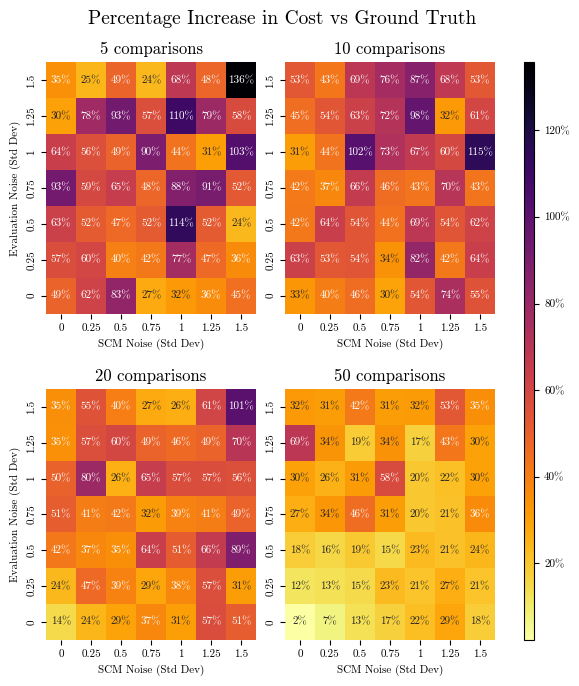

In [18]:
# Sample data
#x_results = np.random.randn(7,7,4)

n_comparisons = [5, 10, 20, 50]

# Determine global minimum and maximum values for consistent colormap
global_vmin = np.min(x_results)
global_vmax = np.max(x_results)

# Set up the figure and gridspec
fig = plt.figure(figsize=(6.3,7.5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], height_ratios=[1, 1])

# Add space between rows
gs.update(hspace=0.3)  # Adjust this value to increase/decrease space


ticks = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
tick_locations = np.arange(0.5, 7.5)  # Centering the ticks
titles = ["Title 1", "Title 2", "Title 3", "Title 4"]

for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])
        sns.heatmap(x_results[:,:,i*2 + j], annot=True, fmt='.0%', cmap='inferno_r', cbar=False, ax=ax, vmin=global_vmin, vmax=global_vmax)
        ax.set_title(f"{n_comparisons[i*2 + j]} comparisons", fontsize=12)
        ax.set_xlabel('SCM Noise (Std Dev)')
        if j == 0:  # Only set y-label for the leftmost heatmaps
            ax.set_ylabel('Evaluation Noise (Std Dev)')
        ax.set_xticks(tick_locations)
        ax.set_yticks(tick_locations)
        ax.set_xticklabels(ticks)
        ax.set_yticklabels(ticks)
        ax.invert_yaxis()

# Add a colorbar to the right of the subplots
cbar_ax = plt.subplot(gs[:, 2])
norm = plt.Normalize(x_results.min(), x_results.max())
sm = plt.cm.ScalarMappable(cmap='inferno_r', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax, format=PercentFormatter(1))
norm = plt.Normalize(global_vmin, global_vmax)  # Set consistent normalization
#cbar.set_label('Percentage Increase in Cost vs Ground Truth', rotation=90, labelpad=5, fontsize=10)  # Add label to colorbar
# Add title
fig.suptitle('Percentage Increase in Cost vs Ground Truth', fontsize=14, y=0.95)

# save plot
plt.savefig('plots/heatmap_single.png', dpi=300, bbox_inches='tight')

plt.show()